# IMPORT LIBRARIES

In [1]:
# Import necessary libraries
from pyDOE2 import fullfact  # for generating full factorial designs
import numpy as np  # for numerical operations
import pandas as pd  # for data manipulation and analysis
import matplotlib.pyplot as plt  # for creating plots
import itertools  # for iterators and looping functions
import math  # for mathematical operations
import statsmodels.formula.api as smf  # for statistical modeling
from statsmodels.formula.api import ols  # for ordinary least squares regression
import statsmodels.api as sm  # for statistical analysis and modeling
from mpl_toolkits.mplot3d import Axes3D  # for creating 3D plots
import itertools
import BiQ_Common_Fxns as BiQ
from patsy import dmatrix
import re
from itertools import combinations
from itertools import permutations
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D axes
from statsmodels.regression.linear_model import RegressionResultsWrapper
from scipy.optimize import minimize


# EXTRACT DATA FROM WORKSHEET

In [2]:
# Initialize a global variable to store DataFrame read from Excel
global_df = None

def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    global global_df  # Access the global DataFrame variable
    try:
        df = pd.read_excel(file_path)  # Read Excel file into a temporary DataFrame
        df = df.dropna(axis=1, how='all')  # Drop columns that are entirely blank
        global_df = df.copy()  # Assign the modified DataFrame to the global variable
        return global_df  # Return the DataFrame
    except Exception as e:
        print(f"Error reading Excel file: {e}")  # Print error message if file reading fails
        return None  # Return None if an error occurs

def extract_factor_values(df, factors_column):
    """Extracts unique factor values from the specified column."""
    try:
        factor_values = df[factors_column].dropna().unique()  # Extract unique factor values from specified column
        return factor_values  # Return the unique factor values
    except Exception as e:
        print(f"Error extracting factor values: {e}")  # Print error message if extraction fails
        return None  # Return None if an error occurs

def process_excel_file(file_paths):
    """Processes the selected Excel file."""
    if file_paths:  # Check if file paths are provided
        results_file = file_paths[0]  # Get the first file path from the list
        factors_column = 'Factor'  # Define the column name containing factors
        df = read_excel_file(results_file)  # Read Excel file into DataFrame
        if df is not None:  # Check if DataFrame is successfully loaded
            factor_values = extract_factor_values(df, factors_column)  # Extract factor values from DataFrame
            return df, factor_values  # Return the DataFrame and factor values
    return None, None  # Return None for DataFrame and factor values if file loading fails

def main():
    file_paths, _ = BiQ.open_file_dialog()  # Open a file dialog to select Excel file(s)

    if file_paths:  # Check if file paths are provided
        results_file = file_paths[0]  # Get the first file path from the list
        df = read_excel_file(results_file)  # Read Excel file into DataFrame
        if df is not None:  # Check if DataFrame is successfully loaded
            # Perform additional processing logic here
            pass
    else:
        print("No file selected.")  # Print message if no file is selected

# Call the main function if the script is executed directly
if __name__ == "__main__":
    main()


Selected files:
C:/Users/ChrisSaid/OneDrive - Boulder BioMed/Documents/SEAL_DOE_OPTIMZATION_CS30APR2024.xlsx [SEAL_DOE_OPTIMZATION_CS30APR2024.xlsx]


# ANALYSIS

## MODEL CREATION

In [3]:

# Extract unique non-nan values from the 'Factor' column and convert them to strings
factors = [str(factor) for factor in global_df['Factor'].unique() if pd.notnull(factor)]

# Generate combinations of two factors
factor_combinations = list(itertools.combinations(factors, 2))

# Construct the formula string
formula_parts = []

# Add individual factors
formula_parts.extend(factors)

# Generate interaction terms
interaction_terms = [f'{f1}:{f2}' for f1, f2 in factor_combinations]
formula_parts.extend(interaction_terms)

# Generate terms up to quadratic terms using np.power()
quadratic_terms = [f'np.power({factor}, 2)' for factor in factors]
formula_parts.extend(quadratic_terms)

formula_string = 'Results ~ ' + ' + '.join(formula_parts)

print("\n\n\nModel Formula: ")
print(formula_string)

# Fit the model using ordinary least squares (OLS)
# This step performs the regression analysis
model = sm.formula.ols(formula_string, data=global_df).fit()            




Model Formula: 
Results ~ TEMP_F + TIME_SEC + PRESSURE_PSI + TEMP_F:TIME_SEC + TEMP_F:PRESSURE_PSI + TIME_SEC:PRESSURE_PSI + np.power(TEMP_F, 2) + np.power(TIME_SEC, 2) + np.power(PRESSURE_PSI, 2)


## MODEL SUMMARY

In [4]:
# Print model summary
print("\n\n\n")
print("=" * 80)
print("MODEL SUMMARY".center(80))
print("=" * 80)
print("This summary provides information about the regression analysis results.")
print("~ R-squared (R²): Measures the proportion of the variance in the dependent variable explained by the independent variables.")
print("~ Adjusted R-squared (Adj. R²): Adjusts R-squared for the number of predictors.")
print("~ Coefficients: Represent the estimated change in the dependent variable for a one-unit change in the predictor.")
print("~ p-value: Indicates the probability of observing the effect if the null hypothesis (no effect) is true.")
print("  A lower p-value suggests that the predictor is statistically significant.\n")

print(model.summary())




========================================================= MODEL SUMMARY =========================================================
This summary provides information about the regression analysis results.
~ R-squared (R²): Measures the proportion of the variance in the dependent variable explained by the independent variables.
~ Adjusted R-squared (Adj. R²): Adjusts R-squared for the number of predictors.
~ Coefficients: Represent the estimated change in the dependent variable for a one-unit change in the predictor.
~ p-value: Indicates the probability of observing the effect if the null hypothesis (no effect) is true.
  A lower p-value suggests that the predictor is statistically significant.


                            OLS Regression Results                            
Dep. Variable:                Results   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:     

c:\Users\ChrisSaid\anaconda3\envs\BiQ_env_20231205\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


## MODEL DIAGNOSTICS




================================== MODEL DIAGNOSTIC PLOTS ==================================
1. Residuals vs. Fits:
   ~ Check for heteroscedasticity (unequal variance) pattern.
       ~ Ideally, residuals should be randomly scattered around the horizontal line at y=0.
    
2. Residuals vs. Order:
   ~ Look for any patterns or trends in residuals across the order of data collection.
   ~ Absence of patterns indicates independence of residuals over time.
    
3. Q-Q Plot:
   ~ Assess the normality of residuals.
   ~ Points should closely follow the diagonal line for normal distribution.


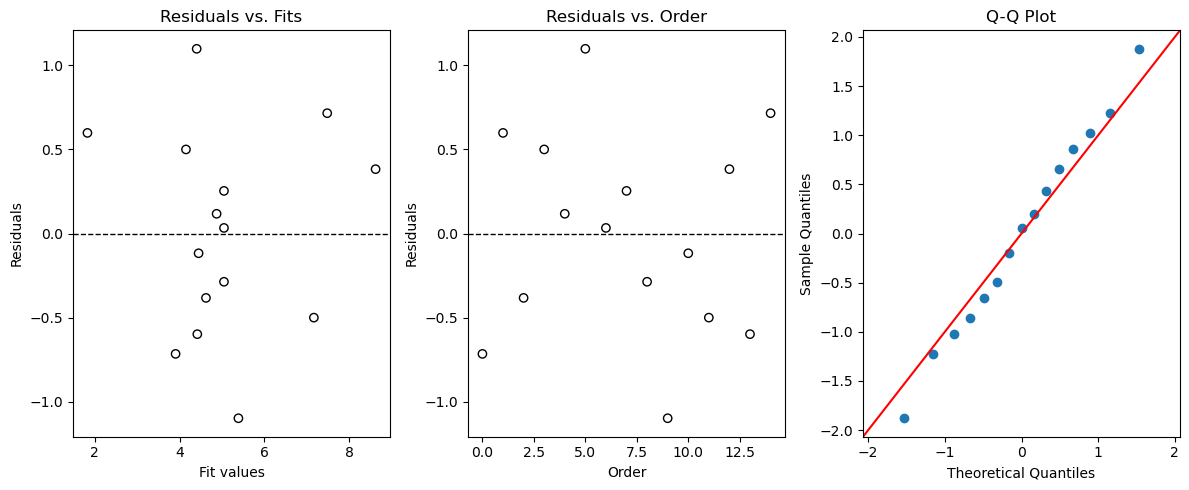

In [5]:
def diagnostic_plots(model):
    # Extract residuals and predicted values from the model
    residuals = model.resid
    predicted = model.fittedvalues
    
    # Print interpretation string
    print("\n\n\n")
    print("=" * 80)
    print("DIAGNOSTIC PLOTS".center(80))
    print("=" * 80)
    print("""
1. Residuals vs. Fits:
   ~ Check for heteroscedasticity (unequal variance) pattern.
       ~ Ideally, residuals should be randomly scattered around the horizontal line at y=0.
    
2. Residuals vs. Order:
   ~ Look for any patterns or trends in residuals across the order of data collection.
   ~ Absence of patterns indicates independence of residuals over time.
    
3. Q-Q Plot:
   ~ Assess the normality of residuals.
   ~ Points should closely follow the diagonal line for normal distribution.""")
    print("=" * 80)
    
    # Create subplots with one row and three columns
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))  # Creating a figure and axes for subplots
    
    # Residuals vs Fits
    axs[0].scatter(predicted, residuals, edgecolors='k', facecolors='none')  # Scatter plot of predicted vs residuals
    axs[0].axhline(y=0, color='k', linestyle='dashed', linewidth=1)  # Horizontal line at y=0
    axs[0].set_title('Residuals vs. Fits')  # Setting title for the subplot
    axs[0].set_xlabel('Fit values')  # Setting label for x-axis
    axs[0].set_ylabel('Residuals')  # Setting label for y-axis
    
    # Residuals vs. Order (Order of Data Collection)
    axs[1].scatter(range(len(residuals)), residuals, edgecolors='k', facecolors='none')  # Scatter plot of residuals vs runs
    axs[1].axhline(y=0, color='k', linestyle='dashed', linewidth=1)  # Horizontal line at y=0
    axs[1].set_title('Residuals vs. Order')  # Setting title for the subplot
    axs[1].set_xlabel('Order')  # Setting label for x-axis
    axs[1].set_ylabel('Residuals')  # Setting label for y-axis
    
    # Q-Q plot
    sm.qqplot(residuals, line='45', fit=True, ax=axs[2])  # Q-Q plot of residuals
    axs[2].set_title('Q-Q Plot')  # Setting title for the subplot
    
    plt.tight_layout()  # Adjusting layout to prevent overlap
    plt.show()  # printing the plots

diagnostic_plots(model)

## 3D SURFACE PLOTS

### HELD VALUE = 1





==================================== 3D SURFACE PLOTS ====================================
~ Each subplot represents a 3D surface plot showing the relationship between two factors.
~ The z-axis represents the 'Results' obtained from the predictive model.
~ Factors other than the plotted ones are held constant at the specified value.


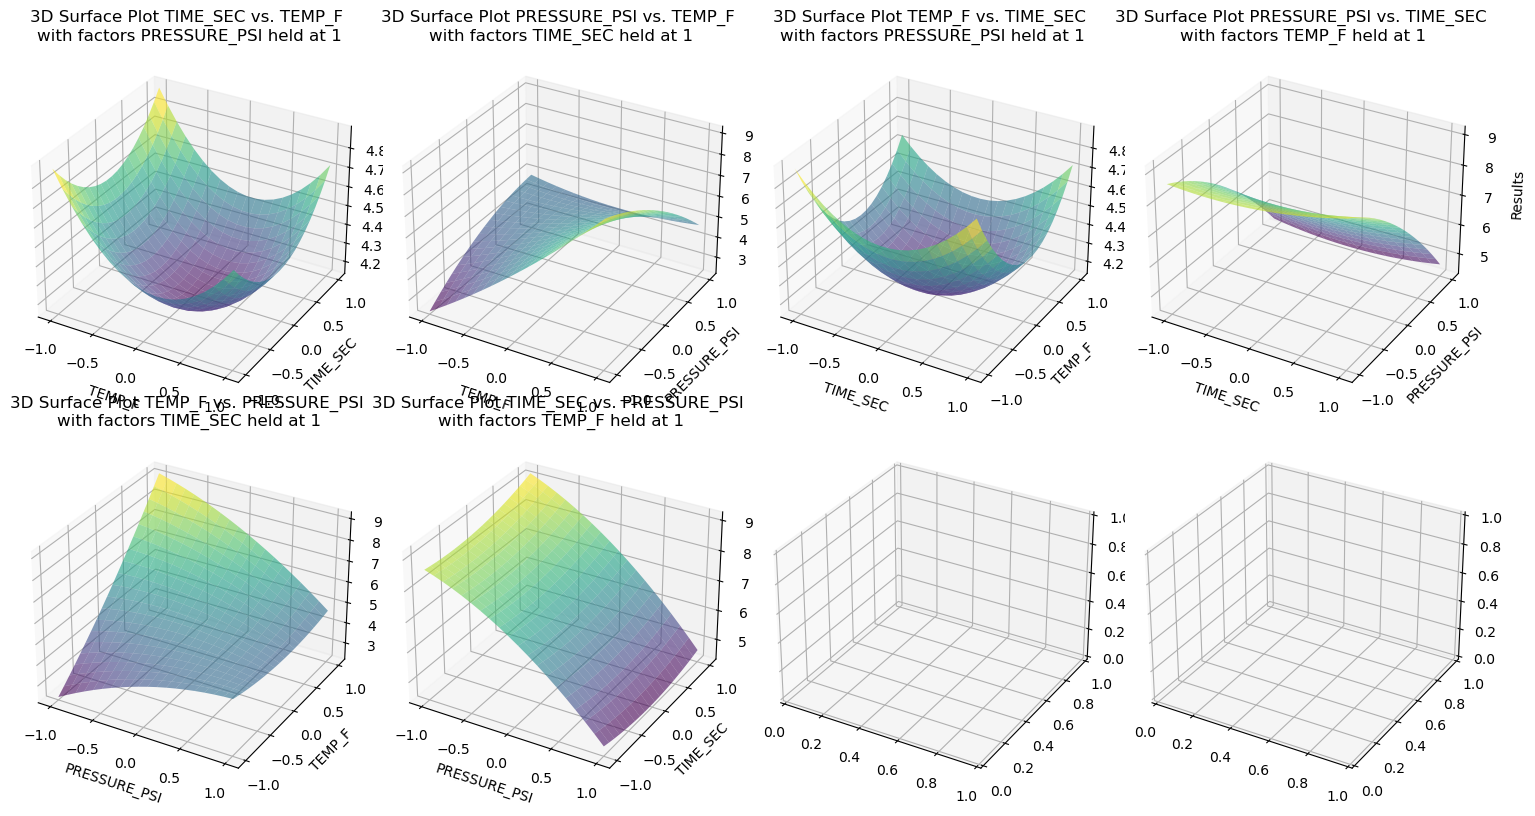

In [6]:
def plot_3D_surface(title, df, model, held_value, num_values=20):
    """
    Plots 3D surface plots based on the DataFrame, model, held_value, and number of values.
    
    Args:
    - title (str): Title of the plot.
    - df (pd.DataFrame): DataFrame containing the data.
    - model: Predictive model.
    - held_value: Value held constant for factors not included in the plot.
    - num_values (int): Number of values to use for generating surface plots.
    """
    if df is None or df.empty:
        print("DataFrame is empty.")
        return

    # Filter columns based on unique values in the 'Factor' column
    factors = df['Factor'].unique()
    factor_columns = [col for col in factors if col in df.columns]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factor_columns, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4), subplot_kw={'projection': '3d'})
    
    # Interpretation string
    print("\n\n\n")
    print("=" * 80)
    print("SURFACE PLOTS".center(80))
    print("=" * 80)
    print("""
~ Each subplot represents a 3D surface plot showing the relationship between two factors.
~ The z-axis represents the 'Results' obtained from the predictive model.
~ Factors other than the plotted ones are held constant at the specified value.""")
    print("=" * 80)


    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factor_columns if factor != x_name and factor != y_name]

        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()

        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a DataFrame
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result

        # Plotting the surface
        ax = axes[i // 4, i % 4]
        ax.plot_surface(A_values, B_values, Z, cmap='viridis', alpha=0.6)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel('Results')
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')

    plt.tight_layout()
    plt.show()

plot_3D_surface("3D Surface Plot", global_df, model, 1)

### HELD VALUE = -1





==================================== 3D SURFACE PLOTS ====================================
~ Each subplot represents a 3D surface plot showing the relationship between two factors.
~ The z-axis represents the 'Results' obtained from the predictive model.
~ Factors other than the plotted ones are held constant at the specified value.


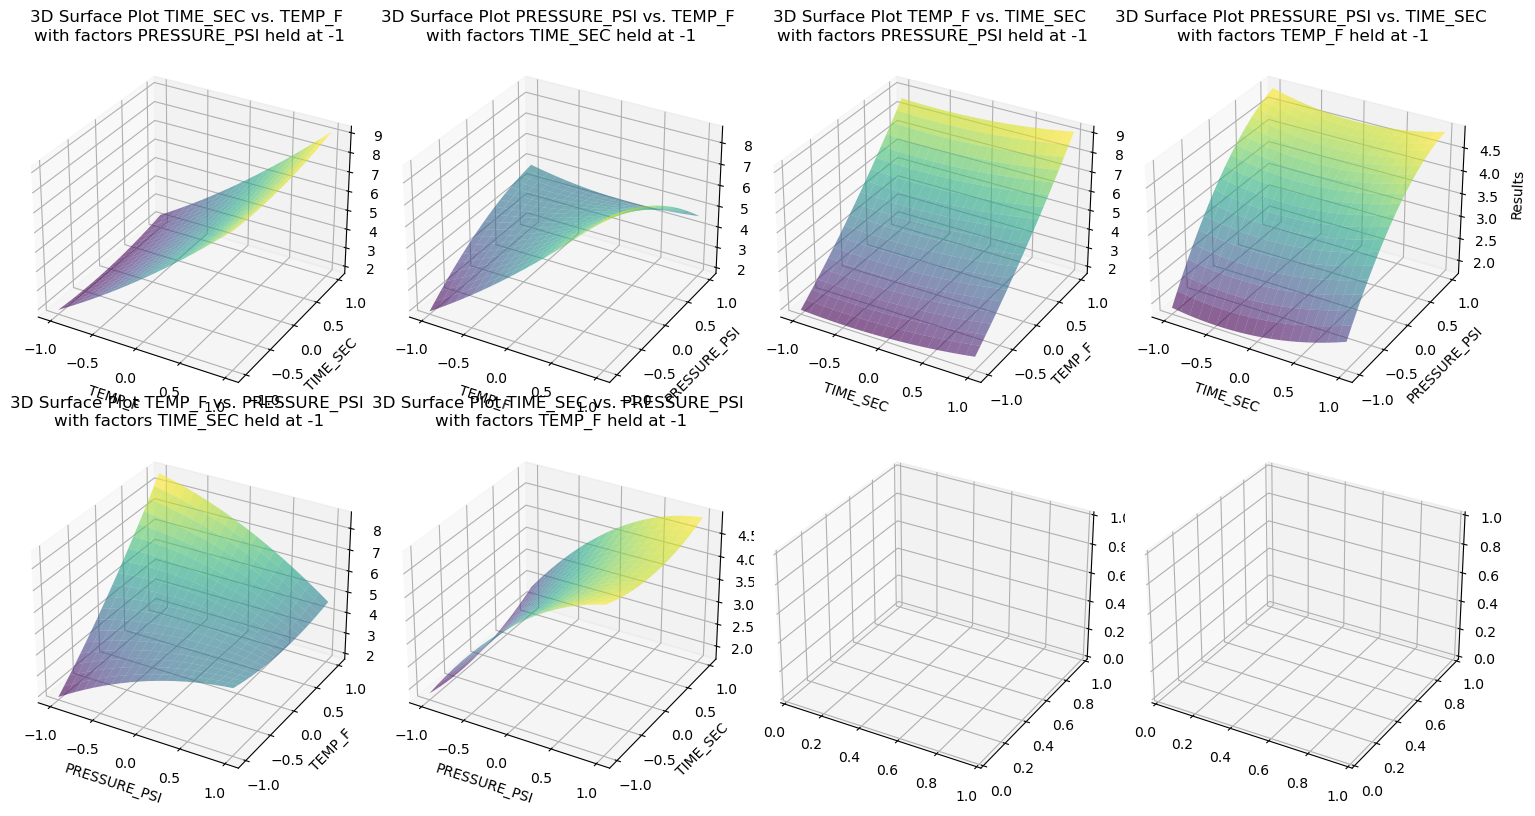

In [7]:
def plot_3D_surface(title, df, model, held_value, num_values=20):
    """
    Plots 3D surface plots based on the DataFrame, model, held_value, and number of values.
    
    Args:
    - title (str): Title of the plot.
    - df (pd.DataFrame): DataFrame containing the data.
    - model: Predictive model.
    - held_value: Value held constant for factors not included in the plot.
    - num_values (int): Number of values to use for generating surface plots.
    """
    if df is None or df.empty:
        print("DataFrame is empty.")
        return

    # Filter columns based on unique values in the 'Factor' column
    factors = df['Factor'].unique()
    factor_columns = [col for col in factors if col in df.columns]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factor_columns, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4), subplot_kw={'projection': '3d'})

    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factor_columns if factor != x_name and factor != y_name]

        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()

        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a DataFrame
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result

        # Plotting the surface
        ax = axes[i // 4, i % 4]
        ax.plot_surface(A_values, B_values, Z, cmap='viridis', alpha=0.6)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel('Results')
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')

    plt.tight_layout()
    plt.show()

plot_3D_surface("3D Surface Plot", global_df, model, -1)

## CONTOUR PLOTS

### HELD VALUE = 1





============================== CONTOUR PLOTS==============================
~ Each contour line represents a region of constant predicted values.
~ Factors other than the plotted ones are held constant at the specified value.


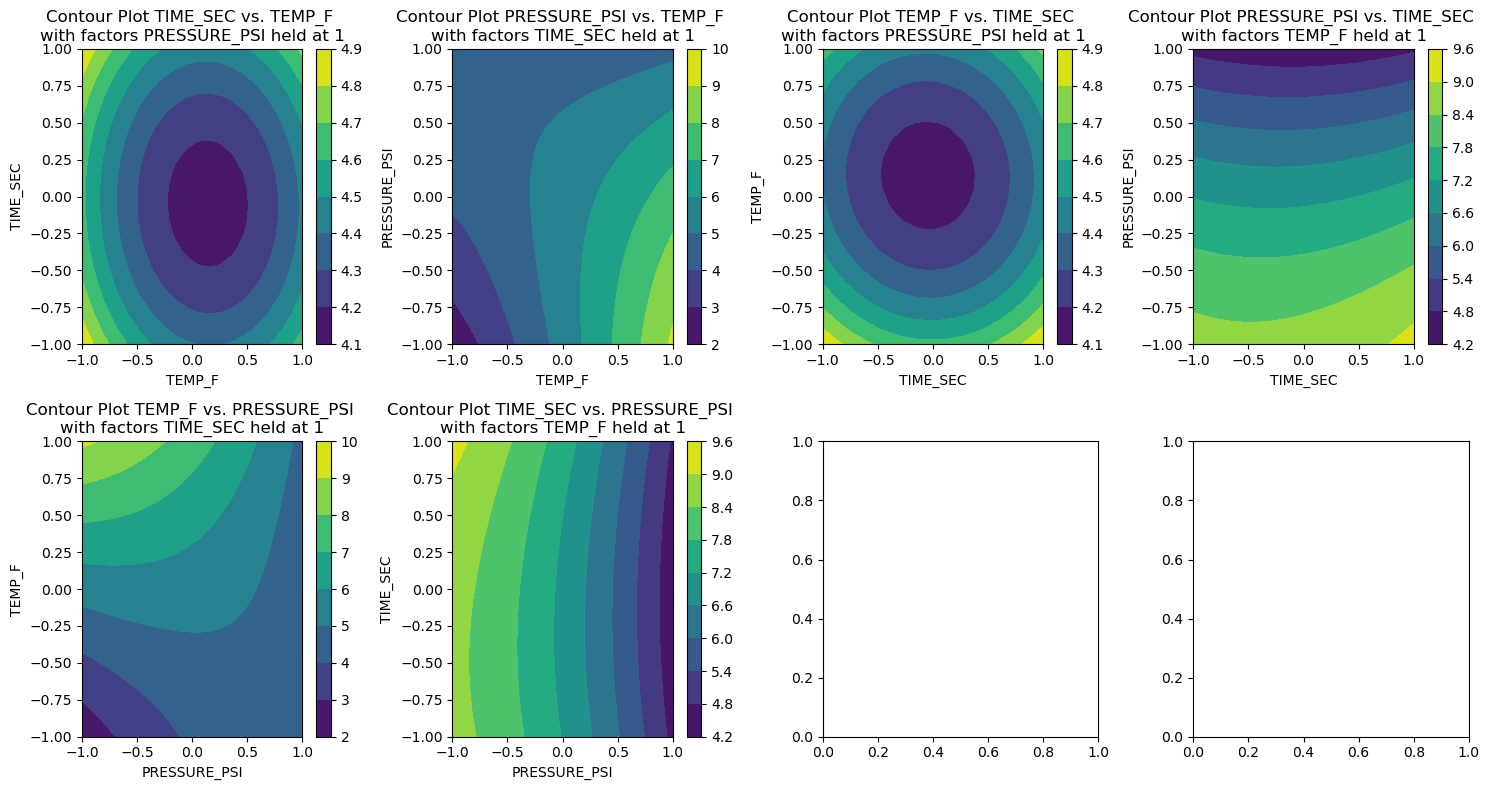

In [8]:
def plot_contour(title, df, model, held_value, num_values=20):
    """
    Plots contour plots based on the DataFrame, model, held_value, and number of values.
    
    Args:
    - title (str): Title of the plot.
    - df (pd.DataFrame): DataFrame containing the data.
    - model: Predictive model.
    - held_value: Value held constant for factors not included in the plot.
    - num_values (int): Number of values to use for generating contour plots.
    """
    if df is None or df.empty:
        print("DataFrame is empty.")
        return

    # Filter columns based on unique values in the 'Factor' column
    factors = df['Factor'].unique()
    factor_columns = [col for col in factors if col in df.columns]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factor_columns, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))

    # Interpretation string
    print("\n\n\n")
    print("=" * 80)
    print("CONTOUR PLOTS".center(80))
    print("=" * 80)
    print("""
~ Each contour line represents a region of constant predicted values.
~ Factors other than the plotted ones are held constant at the specified value.""")
    print("=" * 80)

    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factor_columns if factor != x_name and factor != y_name]

        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()

        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a DataFrame
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result

        # Plotting the contour plot
        ax = axes[i // 4, i % 4]
        contour = ax.contourf(A_values, B_values, Z, cmap='viridis')
        fig.colorbar(contour, ax=ax)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')

    plt.tight_layout()
    plt.show()

plot_contour("Contour Plot", global_df, model, 1)

### HELD VALUE = -1

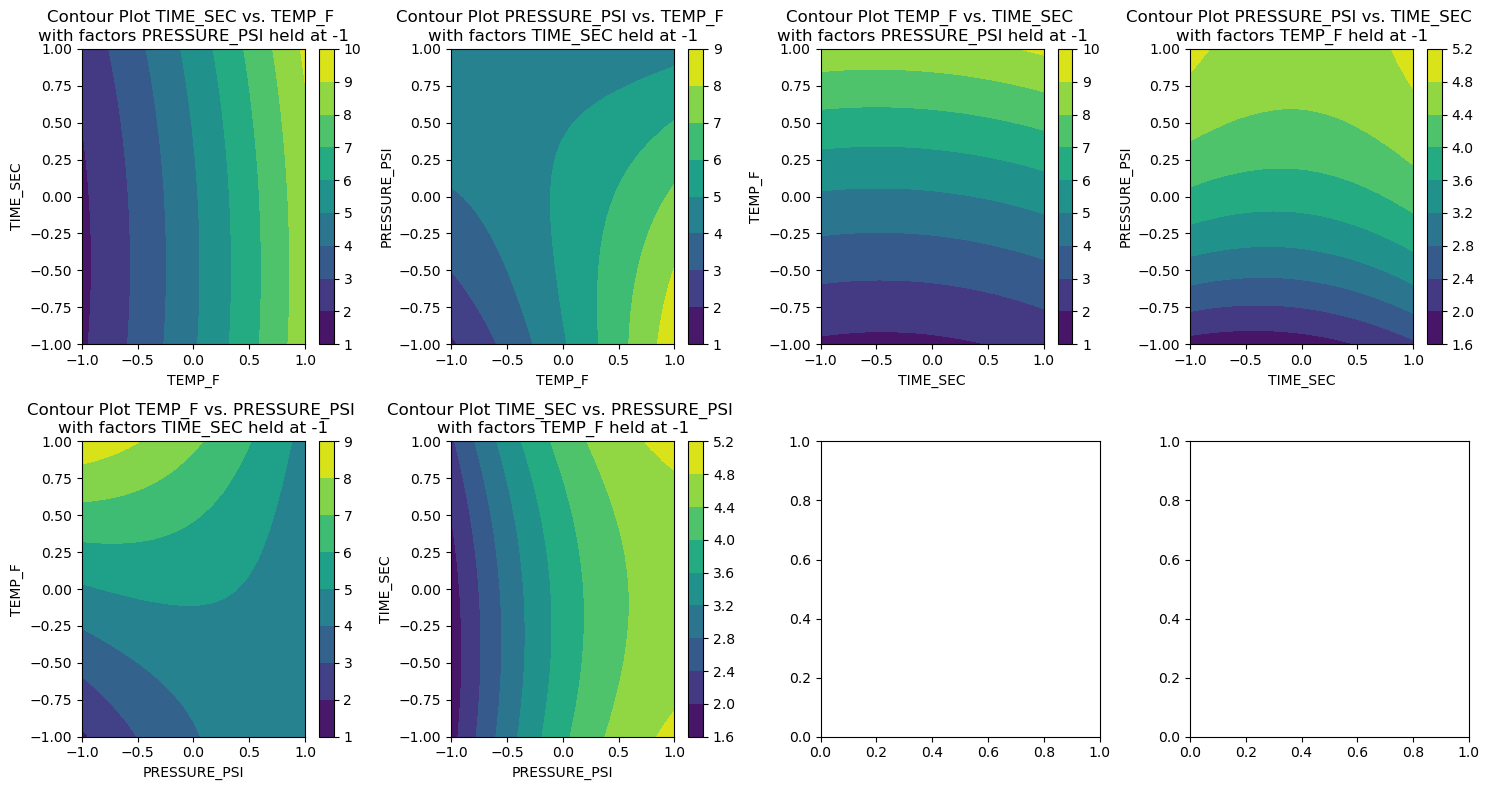

In [9]:
def plot_contour(title, df, model, held_value, num_values=20):
    """
    Plots contour plots based on the DataFrame, model, held_value, and number of values.
    
    Args:
    - title (str): Title of the plot.
    - df (pd.DataFrame): DataFrame containing the data.
    - model: Predictive model.
    - held_value: Value held constant for factors not included in the plot.
    - num_values (int): Number of values to use for generating contour plots.
    """
    if df is None or df.empty:
        print("DataFrame is empty.")
        return

    # Filter columns based on unique values in the 'Factor' column
    factors = df['Factor'].unique()
    factor_columns = [col for col in factors if col in df.columns]

    # Generate all possible combinations of factors for x_name and y_name
    factor_combinations_xy = list(itertools.permutations(factor_columns, 2))

    # Create subplots
    num_plots = len(factor_combinations_xy)
    num_rows = (num_plots + 3) // 4  # Round up to the nearest multiple of 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))

    # Iterate through combinations for x_name and y_name
    for i, (x_name, y_name) in enumerate(factor_combinations_xy):
        # Identify held factors
        held_factors = [factor for factor in factor_columns if factor != x_name and factor != y_name]

        # Get min and max values for x and y
        x_min, x_max = df[x_name].min(), df[x_name].max()
        y_min, y_max = df[y_name].min(), df[y_name].max()

        # Create a DataFrame with all possible values for x and y
        x_values = np.linspace(x_min, x_max, num_values)
        y_values = np.linspace(y_min, y_max, num_values)
        A_values, B_values = np.meshgrid(x_values, y_values)
        Z = np.zeros((len(y_values), len(x_values)))

        # Predict using the model and store data in a DataFrame
        for j, y_val in enumerate(y_values):
            for k, x_val in enumerate(x_values):
                df_pred = pd.DataFrame({
                    x_name: [x_val],
                    y_name: [y_val],
                    **{held_factor: [held_value] for held_factor in held_factors}
                })
                result = model.predict(df_pred)[0]
                Z[j, k] = result

        # Plotting the contour plot
        ax = axes[i // 4, i % 4]
        contour = ax.contourf(A_values, B_values, Z, cmap='viridis')
        fig.colorbar(contour, ax=ax)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_title(f'{title} {y_name} vs. {x_name} \nwith factors {", ".join(held_factors)} held at {held_value}')

    plt.tight_layout()
    plt.show()

plot_contour("Contour Plot", global_df, model, -1)

## RESPONSE OPTIMIZATION

In [10]:
from scipy.optimize import minimize

def gradient_based_optimization(df, model):
    """
    Perform optimization using gradient-based optimization with constraints.

    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - model: Predictive model.

    Returns:
    - dict: Dictionary containing the optimized settings and predicted response values for both max and min.
    """
    if df.empty or model is None:
        return {
            "Maximization Result": {"Optimized Settings": None, "Optimized Response": None},
            "Minimization Result": {"Optimized Settings": None, "Optimized Response": None},
            "Target Result": {"Optimized Settings": None, "Optimized Response": None}
        }

    # Filter columns based on unique values in the 'Factor' column
    factors = df['Factor'].unique()
    factor_columns = [col for col in factors if col in df.columns]

    # Check if 'Target Response' column exists
    if 'Target Response' in df.columns:
        target_response_column = df['Target Response']
        # Check if values in 'Target Response' column are numeric
        if target_response_column.apply(lambda x: isinstance(x, (int, float))).all():
            desired_response_value = target_response_column.iloc[0]  # Take the first value as desired response
        else:
            # If values are not numeric, skip target response calculation
            desired_response_value = None
    else:
        desired_response_value = None

    def objective_function(values):
        data = {factor: [value] for factor, value in zip(factor_columns, values)}
        predicted_response = model.predict(pd.DataFrame(data)).iloc[0]
        return predicted_response

    # Generate initial guess for factor values
    initial_guess = np.zeros(len(factor_columns))

    # Define bounds for factor values
    bounds = [(-1, 1) for _ in factor_columns]

    # Perform gradient-based optimization with bounds for maximum
    result_max = minimize(lambda x: -objective_function(x), initial_guess, method='L-BFGS-B', bounds=bounds)

    # Perform gradient-based optimization with bounds for minimum
    result_min = minimize(objective_function, initial_guess, method='L-BFGS-B', bounds=bounds)

    # Extract optimized settings and predicted response for maximum
    optimized_settings_max = {factor: value for factor, value in zip(factor_columns, result_max.x)}
    optimized_response_max = -result_max.fun  # Maximize

    # Extract optimized settings and predicted response for minimum
    optimized_settings_min = {factor: value for factor, value in zip(factor_columns, result_min.x)}
    optimized_response_min = result_min.fun  # Minimize

    # Find settings closest to the target response if desired_response_value exists
    if desired_response_value is not None:
        result_target = minimize(lambda x: abs(objective_function(x) - desired_response_value), initial_guess, method='L-BFGS-B', bounds=bounds)
        optimized_settings_target = {factor: value for factor, value in zip(factor_columns, result_target.x)}
        optimized_response_target = objective_function(result_target.x)
    else:
        optimized_settings_target = None
        optimized_response_target = None

    return {
        "Maximization Result": {"Optimized Settings": optimized_settings_max, "Optimized Response": optimized_response_max},
        "Minimization Result": {"Optimized Settings": optimized_settings_min, "Optimized Response": optimized_response_min},
        "Target Result": {"Optimized Settings": optimized_settings_target, "Optimized Response": optimized_response_target}
    }

optimization_result_gradient_based = gradient_based_optimization(global_df, model)

# Print an interpretation of the optimization results
print("=" * 80)
print("OPTIMIZATION RESULTS".center(80))
print("=" * 80)
print("These results represent the best settings to achieve the maximum, minimum, or target predicted response values.")
print("Maximized Response Settings:", optimization_result_gradient_based["Maximization Result"]["Optimized Settings"])
print("Maximized Response Value:", optimization_result_gradient_based["Maximization Result"]["Optimized Response"])
print("Minimized Response Settings:", optimization_result_gradient_based["Minimization Result"]["Optimized Settings"])
print("Minimized Response Value:", optimization_result_gradient_based["Minimization Result"]["Optimized Response"])
if optimization_result_gradient_based["Target Result"]["Optimized Settings"] is not None:
    print("Target Response Settings:", optimization_result_gradient_based["Target Result"]["Optimized Settings"])
    print("Target Response Value:", optimization_result_gradient_based["Target Result"]["Optimized Response"])
print("=" * 80)





========================================= OPTIMIZATION RESULTS =========================================
These results represent the best settings to achieve the maximum, minimum, or target predicted response values.
Maximized Response Settings: {'TEMP_F': 1.0, 'TIME_SEC': 1.0, 'PRESSURE_PSI': -1.0}
Maximized Response Value: 9.171416666666662
Minimized Response Settings: {'TEMP_F': -1.0, 'TIME_SEC': -0.4479002971236241, 'PRESSURE_PSI': -1.0}
Minimized Response Value: 1.7692519440124468
Target Response Settings: {'TEMP_F': -0.9677560975509241, 'TIME_SEC': -0.1931425401613622, 'PRESSURE_PSI': 0.7524726423120415}
Target Response Value: 4.499999999460971
